In [1]:
#!pip install scikit-learn
#!pip install graphviz

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import wilcoxon
from scipy import stats
from sklearn.model_selection import train_test_split

<h1>EDA</h1>

In [3]:
df=pd.read_csv('churn.csv')
df = df.rename(columns=str.lower)

original_df = df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [4]:
print('Number of rows:',df.shape[0]) 
print('Number of columns:',df.shape[1]) 

Number of rows: 7043
Number of columns: 21


In [5]:
df.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [6]:
print(f"The amount of duplicated numbers are {df.duplicated().sum()}")

The amount of duplicated numbers are 0


In [7]:
df.head(20)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [8]:
# הפכיה לערכים מספריים על מנת להציג את הנתונים
df['totalcharges'] = df['totalcharges'].str.strip() 
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df.isnull().sum()


customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [9]:
# הצגת השורות הבעייתיות
problem_rows = df[df['totalcharges'].isna()]

problem_rows = problem_rows[['customerid', 'totalcharges']]

print(problem_rows['customerid'].count(),problem_rows)

11       customerid  totalcharges
488   4472-LVYGI           NaN
753   3115-CZMZD           NaN
936   5709-LVOEQ           NaN
1082  4367-NUYAO           NaN
1340  1371-DWPAZ           NaN
3331  7644-OMVMY           NaN
3826  3213-VVOLG           NaN
4380  2520-SGTTA           NaN
5218  2923-ARZLG           NaN
6670  4075-WKNIU           NaN
6754  2775-SEFEE           NaN


In [10]:
df = df.dropna(subset=['totalcharges'])

In [11]:
df.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [12]:
df_diff = pd.DataFrame()
df_diff['diff'] = df['totalcharges'] - (df['monthlycharges']*df['tenure'])
# if the number is negative we assume the price raised during the tenure
# if the number is 0 there was no change in price during the tenure
# if the number is positive we assume the price dropped during the tenure

df_diff['price_remain'] = (df_diff['diff'] == 0).astype(int)
df_diff['price_raised'] = (df_diff['diff'] < 0).astype(int)
df_diff['price_dropped'] = (df_diff['diff'] > 0).astype(int)
df_diff['churned'] = df['churn']

df2 = df_diff.groupby('churned')['diff'].agg(['mean', 'std'])
df2

,mean,std
churned,,
No,0.140858,70.948991
Yes,0.187266,55.812596


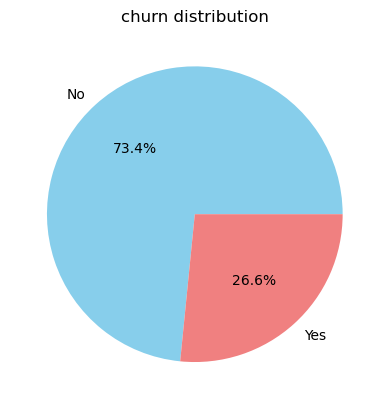

In [13]:
df['churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('churn distribution')
plt.ylabel('') 
plt.show()


/var/folders/4_/wc7y9d953kx0rs3vk8lkbcjh0000gq/T/ipykernel_40593/751011585.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn', data=df, palette='Set2')


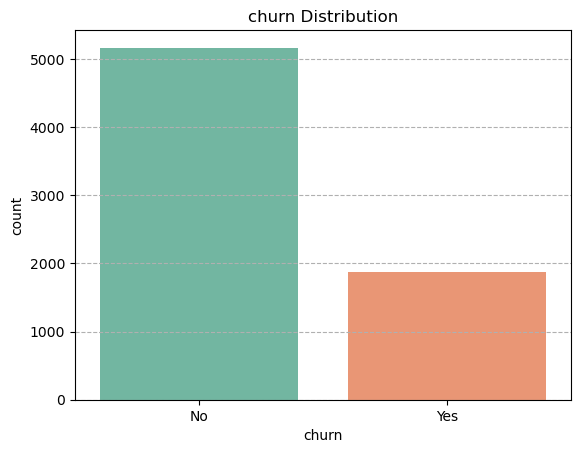

In [14]:
#3. התפלגות משתנה עזיבה  (לפני חלוקה):
sns.countplot(x='churn', data=df, palette='Set2')
plt.title('churn Distribution')
plt.grid(axis='y', linestyle='--')
plt.show()

In [15]:
df[['tenure']].describe()

,tenure
count,7032.000000
mean,32.421786
std,24.545260
min,1.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,72.000000


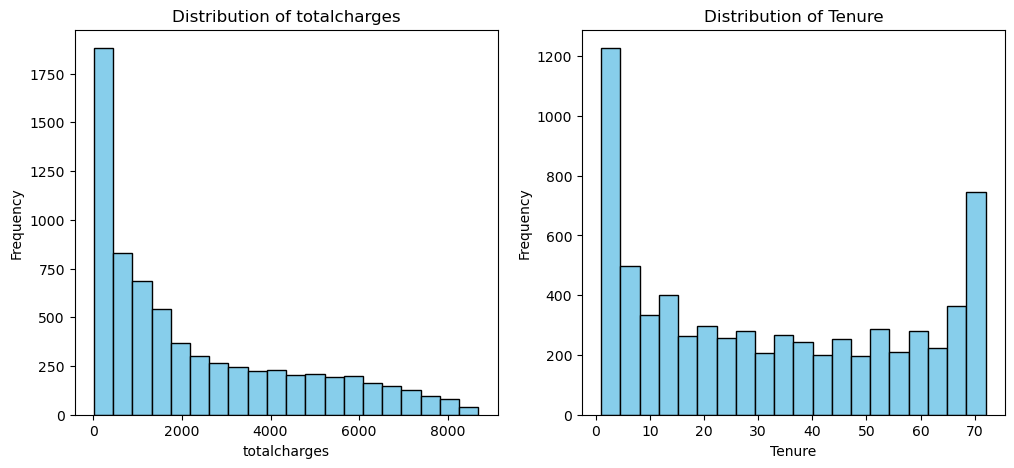

In [16]:
#פירוט 1
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# גרף 1 התפלגות totalcharges
axes[0].hist(df['totalcharges'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of totalcharges')
axes[0].set_xlabel('totalcharges')
axes[0].set_ylabel('Frequency')

# גרף 2 התפלגות Tenure
axes[1].hist(df['tenure'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('Distribution of Tenure')
axes[1].set_xlabel('Tenure')
axes[1].set_ylabel('Frequency')

plt.show()

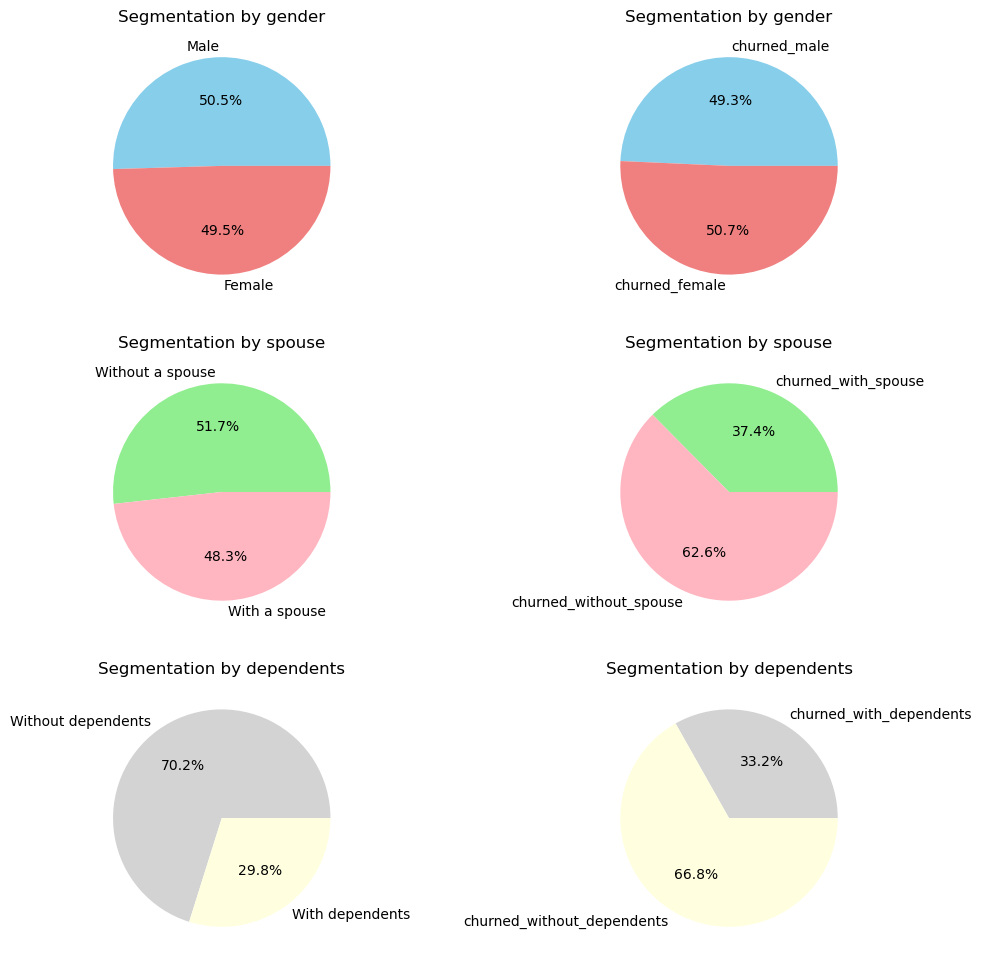

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# פילוח לפי מגדר
gender_counts = df['gender'].value_counts()
axes[0, 0].pie(gender_counts, labels=["Male", "Female"], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[0, 0].set_title('Segmentation by gender')

def get_churned_percentage(group_name, group_value):
    churned_group_a_count = df[(df[group_name]==group_value) & (df['churn']=='Yes')].shape[0]
    total_group_a_count = df[df[group_name]==group_value].shape[0]
    return (churned_group_a_count/total_group_a_count)

group_a_percentage = get_churned_percentage('gender', 'Male')
group_b_percentage = get_churned_percentage('gender', 'Female')
axes[0, 1].pie([group_a_percentage,group_b_percentage], labels=["churned_male", "churned_female"], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[0, 1].set_title('Segmentation by gender')

# פילוח לפי בן/בת זוג
partner_counts = df['partner'].value_counts()
axes[1, 0].pie(partner_counts, labels=['Without a spouse','With a spouse'], autopct='%1.1f%%', colors=['lightgreen', 'lightpink'])
axes[1, 0].set_title('Segmentation by spouse')

group_a_percentage = get_churned_percentage('partner', 'Yes')
group_b_percentage = get_churned_percentage('partner', 'No')
axes[1, 1].pie([group_a_percentage,group_b_percentage], labels=["churned_with_spouse", "churned_without_spouse"], autopct='%1.1f%%', colors=['lightgreen', 'lightpink'])
axes[1, 1].set_title('Segmentation by spouse')

# פילוח לפי תלויים
dependents_counts = df['dependents'].value_counts()
axes[2, 0].pie(dependents_counts, labels=['Without dependents', 'With dependents'], autopct='%1.1f%%', colors=['lightgrey', 'lightyellow'])
axes[2, 0].set_title('Segmentation by dependents')

group_a_percentage = get_churned_percentage('dependents', 'Yes')
group_b_percentage = get_churned_percentage('dependents', 'No')
axes[2, 1].pie([group_a_percentage,group_b_percentage], labels=["churned_with_dependents", "churned_without_dependents"], autopct='%1.1f%%', colors=['lightgrey', 'lightyellow'])
axes[2, 1].set_title('Segmentation by dependents')

# # פילוח לפי עזיבה
# churn_counts = df['churn'].value_counts()
# axes[1, 1].pie(churn_counts, labels=['Didn\'t leave', 'Leave'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
# axes[1, 1].set_title('Segmentation by departure')

plt.show()

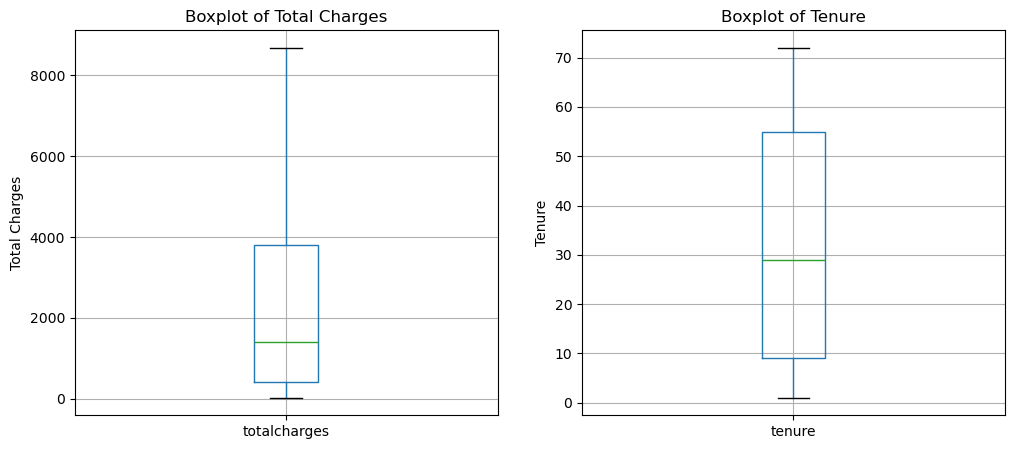

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# גרף 1 Boxplot ל-totalcharges
df.boxplot(column='totalcharges', ax=axes[0])
axes[0].set_title('Boxplot of Total Charges')
axes[0].set_ylabel('Total Charges')

# גרף 2 Boxplot ל-Tenure
df.boxplot(column='tenure', ax=axes[1])
axes[1].set_title('Boxplot of Tenure')
axes[1].set_ylabel('Tenure')

plt.show()

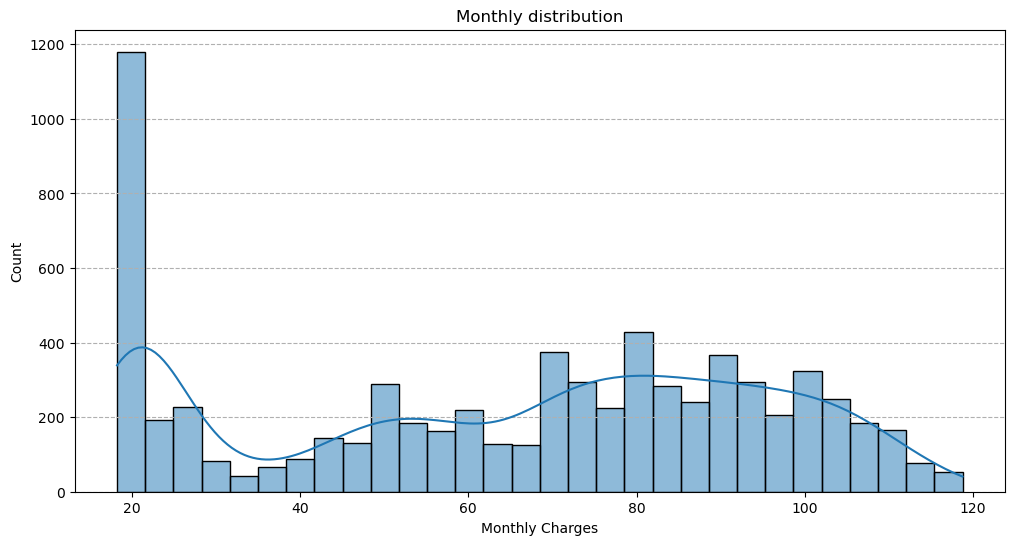

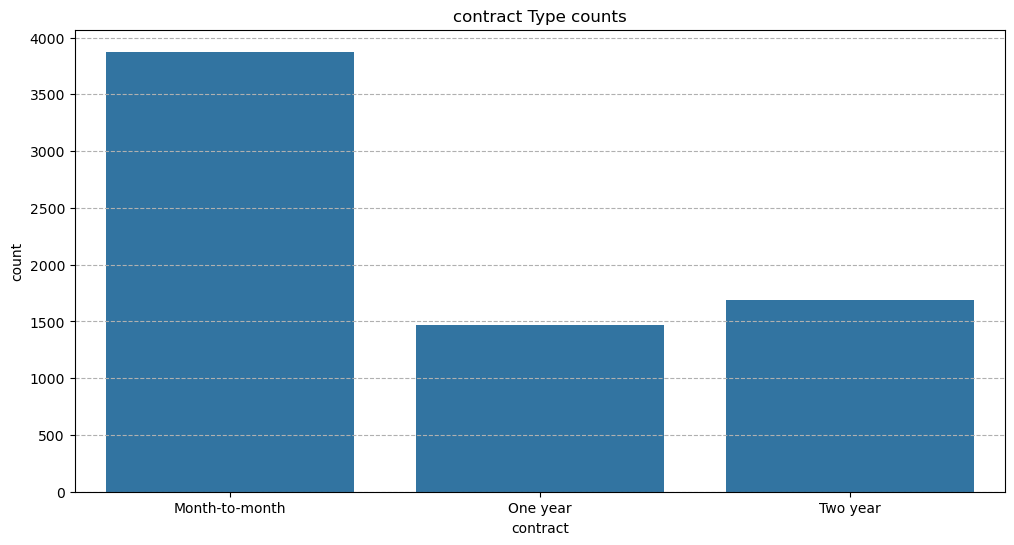

In [19]:
#  גרף התפלגות עמודה מספרית (monthlycharges)
plt.figure(figsize=(12, 6))
sns.histplot(df['monthlycharges'], bins=30, kde=True)
plt.title('Monthly distribution')
plt.xlabel('Monthly Charges')
plt.grid(axis='y', linestyle='--')
plt.show()

#  גרף פילוח לפי contract ו-churn
plt.figure(figsize=(12, 6))
sns.countplot(x='contract',  data=df) 
plt.title('contract Type counts')
plt.grid(axis='y', linestyle='--')
plt.show()

<h1>Data Engineering / Prep </h1>

In [20]:
def create_dummies(data_frame, column_name):
    return pd.get_dummies(data_frame, columns=[column_name], prefix=column_name, drop_first=True,dtype=int)

In [21]:
df['charge_diff'] = df['totalcharges'] - (df['monthlycharges']*df['tenure'])
# if the number is negative we assume the price raised during the tenure
# if the number is 0 there was no change in price during the tenure
# if the number is positive we assume the price dropped during the tenure
df['price_remain'] = (df['charge_diff'] == 0).astype(int)
df['price_raised'] = (df['charge_diff'] < 0).astype(int)
df['price_dropped'] = (df['charge_diff'] > 0).astype(int)


df.loc[df.churn == 'No','churn'] =0
df.loc[df.churn == 'Yes','churn'] =1
df['churn'] = df['churn'].astype(int)

df.loc[df.gender == 'Male','gender']=0
df.loc[df.gender == 'Female','gender']=1
df['gender'] = df['gender'].astype(int)

df.loc[df.partner == 'No','partner']=0
df.loc[df.partner == 'Yes','partner']=1
df['partner'] = df['partner'].astype(int)

df.loc[df.dependents == 'No','dependents']=0
df.loc[df.dependents == 'Yes','dependents']=1
df['dependents'] = df['dependents'].astype(int)

df.loc[df.phoneservice == 'No','phoneservice'] =0
df.loc[df.phoneservice == 'Yes','phoneservice'] =1
df['phoneservice'] = df['phoneservice'].astype(int)

df.loc[df.paperlessbilling == 'No','paperlessbilling'] = 0
df.loc[df.paperlessbilling == 'Yes','paperlessbilling'] =1
df['paperlessbilling'] = df['paperlessbilling'].astype(int)

df = create_dummies(df, 'contract')
df = create_dummies(df, 'multiplelines')
df = create_dummies(df, 'internetservice')
df = create_dummies(df, 'onlinesecurity')
df = create_dummies(df, 'onlinebackup')
df = create_dummies(df, 'deviceprotection')
df = create_dummies(df, 'techsupport')
df = create_dummies(df, 'streamingtv')
df = create_dummies(df, 'streamingmovies')
df = create_dummies(df, 'paymentmethod')

customer_id = df['customerid']

print(df.info())
df.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerid                             7032 non-null   object 
 1   gender                                 7032 non-null   int64  
 2   seniorcitizen                          7032 non-null   int64  
 3   partner                                7032 non-null   int64  
 4   dependents                             7032 non-null   int64  
 5   tenure                                 7032 non-null   int64  
 6   phoneservice                           7032 non-null   int64  
 7   paperlessbilling                       7032 non-null   int64  
 8   monthlycharges                         7032 non-null   float64
 9   totalcharges                           7032 non-null   float64
 10  churn                                  7032 non-null   int64  
 11  charge_di

/var/folders/4_/wc7y9d953kx0rs3vk8lkbcjh0000gq/T/ipykernel_40593/2369239894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['charge_diff'] = df['totalcharges'] - (df['monthlycharges']*df['tenure'])
/var/folders/4_/wc7y9d953kx0rs3vk8lkbcjh0000gq/T/ipykernel_40593/2369239894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_remain'] = (df['charge_diff'] == 0).astype(int)
/var/folders/4_/wc7y9d953kx0rs3vk8lkbcjh0000gq/T/ipykernel_40593/2369239894.py:6: SettingWithCopyWarning: 
A value is try

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,...,deviceprotection_Yes,techsupport_No internet service,techsupport_Yes,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,...,1,0,0,0,0,0,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,1,0,1,0,0,0,0,0,0,0
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,0,0,0,0,0,0,0,0,1,0
5,9305-CDSKC,1,0,0,0,8,1,1,99.65,820.50,...,1,0,0,0,1,0,1,0,1,0
6,1452-KIOVK,0,0,0,1,22,1,1,89.10,1949.40,...,0,0,0,0,1,0,0,1,0,0
7,6713-OKOMC,1,0,0,0,10,0,0,29.75,301.90,...,0,0,0,0,0,0,0,0,0,1
8,7892-POOKP,1,0,1,0,28,1,1,104.80,3046.05,...,1,0,1,0,1,0,1,0,1,0
9,6388-TABGU,0,0,0,1,62,1,0,56.15,3487.95,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df['combined'] = df['internetservice_Fiber optic'] | df['internetservice_No'] | \
       df['onlinesecurity_No internet service'] | df['onlinesecurity_Yes'] | \
       df['onlinebackup_No internet service'] | df['onlinebackup_Yes'] | \
       df['deviceprotection_No internet service'] | df['deviceprotection_Yes'] | \
       df['techsupport_No internet service'] | df['techsupport_Yes'] | \
       df['streamingtv_No internet service'] | df['streamingtv_Yes'] | \
       df['streamingmovies_No internet service'] | df['streamingmovies_Yes']

sum_all_combined = df['internetservice_Fiber optic'] + df['internetservice_No'] + \
       df['onlinesecurity_No internet service'] + df['onlinesecurity_Yes'] + \
       df['onlinebackup_No internet service'] + df['onlinebackup_Yes'] + \
       df['deviceprotection_No internet service'] + df['deviceprotection_Yes'] + \
       df['techsupport_No internet service'] + df['techsupport_Yes'] + \
       df['streamingtv_No internet service'] + df['streamingtv_Yes'] + \
       df['streamingmovies_No internet service'] + df['streamingmovies_Yes']
df['combined_majority'] = (sum_all_combined > 6).astype(int)

df.drop(['internetservice_Fiber optic', 'internetservice_No','onlinesecurity_No internet service','onlinesecurity_Yes'], axis=1, inplace=True)
df.drop(['onlinebackup_No internet service','onlinebackup_Yes','deviceprotection_No internet service', 'deviceprotection_Yes'], axis=1, inplace=True)
df.drop(['techsupport_No internet service', 'techsupport_Yes','streamingtv_No internet service', 'streamingtv_Yes'], axis=1, inplace=True)
df.drop(['streamingmovies_No internet service', 'streamingmovies_Yes'], axis=1, inplace=True)
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,...,price_dropped,contract_One year,contract_Two year,multiplelines_No phone service,multiplelines_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,combined,combined_majority
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,0,0,0,1,0,0,1,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,...,0,1,0,0,0,0,0,1,1,0
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,1,0,0,0,0,0,0,1,1,0
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,0,1,0,1,0,0,0,0,1,0
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1,24,1,1,84.80,1990.50,...,0,1,0,0,1,0,0,1,1,0
7039,2234-XADUH,1,0,1,1,72,1,1,103.20,7362.90,...,0,1,0,0,1,1,0,0,1,0
7040,4801-JZAZL,1,0,1,1,11,0,1,29.60,346.45,...,1,0,0,1,0,0,1,0,1,0
7041,8361-LTMKD,0,1,1,0,4,1,1,74.40,306.60,...,1,0,0,0,1,0,0,1,1,0


In [23]:
df.isnull().sum()

customerid                               0
gender                                   0
seniorcitizen                            0
partner                                  0
dependents                               0
tenure                                   0
phoneservice                             0
paperlessbilling                         0
monthlycharges                           0
totalcharges                             0
churn                                    0
charge_diff                              0
price_remain                             0
price_raised                             0
price_dropped                            0
contract_One year                        0
contract_Two year                        0
multiplelines_No phone service           0
multiplelines_Yes                        0
paymentmethod_Credit card (automatic)    0
paymentmethod_Electronic check           0
paymentmethod_Mailed check               0
combined                                 0
combined_ma

In [24]:
#פירוט 3

# סט 1 חלוקה רחבה
def categorize_tenure_set1(tenure):
    if tenure <= 12:
        return '0-12'
    elif 13 <= tenure <= 36:
        return '13-36'
    elif 37 <= tenure <= 60:
        return '37-60'
    else:
        return '60+'

# סט 2 (6 חודשים)
def categorize_tenure_set2(tenure):
    if tenure <= 6:
        return '0-6'
    elif 7 <= tenure <= 12:
        return '7-12'
    elif 13 <= tenure <= 18:
        return '13-18'
    elif 19 <= tenure <= 24:
        return '19-24'
    elif 25 <= tenure <= 30:
        return '25-30'
    elif 31 <= tenure <= 36:
        return '31-36'
    elif 37 <= tenure <= 42:
        return '37-42'
    elif 43 <= tenure <= 48:
        return '43-48'
    elif 49 <= tenure <= 54:
        return '49-54'
    elif 55 <= tenure <= 60:
        return '55-60'
    else:
        return '60+'

# סט 3 (10 חודשים)
def categorize_tenure_set3(tenure):
    if tenure <= 10:
        return '0-10'
    elif 11 <= tenure <= 20:
        return '11-20'
    elif 21 <= tenure <= 30:
        return '21-30'
    elif 31 <= tenure <= 40:
        return '31-40'
    elif 41 <= tenure <= 50:
        return '41-50'
    elif 51 <= tenure <= 60:
        return '51-60'
    else:
        return '60+'

df['tenure_category_set1'] = df['tenure'].apply(categorize_tenure_set1)
df['tenure_category_set2'] = df['tenure'].apply(categorize_tenure_set2)
df['tenure_category_set3'] = df['tenure'].apply(categorize_tenure_set3)

categories_set1 = ['0-12', '13-36', '37-60', '60+']
categories_set2 = ['0-6', '7-12', '13-18', '19-24', '25-30', '31-36', '37-42', '43-48', '49-54', '55-60', '60+']
categories_set3 = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '60+']

In [25]:
stats_set1 = df.groupby(['churn','tenure_category_set1'])['monthlycharges'].agg(['mean'])
stats_set2 = df.groupby(['churn','tenure_category_set2'])['monthlycharges'].agg(['mean'])
stats_set3 = df.groupby(['churn','tenure_category_set3'])['monthlycharges'].agg(['mean'])

avg_std_set1 = stats_set1.groupby('churn')[['mean']].agg('mean')
avg_std_set2 = stats_set2.groupby('churn')[['mean']].agg('mean')
avg_std_set3 = stats_set3.groupby('churn')[['mean']].agg('mean')

In [26]:
print(stats_set1)
print(avg_std_set1)
print(stats_set2)
print(avg_std_set2)
print(stats_set3)
print(avg_std_set3)

                                 mean
churn tenure_category_set1           
0     0-12                  46.766169
      13-36                 57.264146
      37-60                 64.978405
      60+                   74.440563
1     0-12                  66.493973
      13-36                 80.695359
      37-60                 86.326226
      60+                   97.317742
            mean
churn           
0      60.862321
1      82.708325
                                 mean
churn tenure_category_set2           
0     0-6                   44.775875
      13-18                 53.754582
      19-24                 55.167827
      25-30                 58.506083
      31-36                 62.458095
      37-42                 60.376351
      43-48                 63.453427
      49-54                 66.326847
      55-60                 68.803611
      60+                   74.440563
      7-12                  49.786836
1     0-6                   63.642985
      13-18         

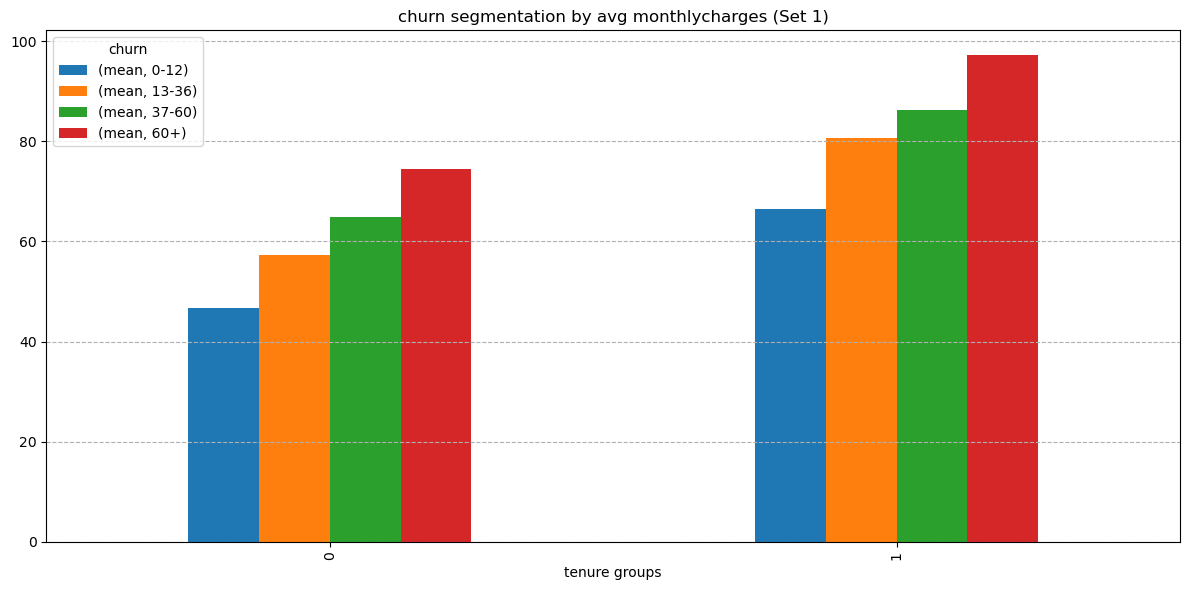

In [27]:
unstacked = stats_set1.unstack()
unstacked.plot(kind='bar', figsize=(12, 6))

#plt.plot(x='tenure_category_set1', hue='churn', data=stats_set1, palette='coolwarm')
plt.title('churn segmentation by avg monthlycharges (Set 1)')
plt.xlabel('tenure groups')
plt.legend(title='churn')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

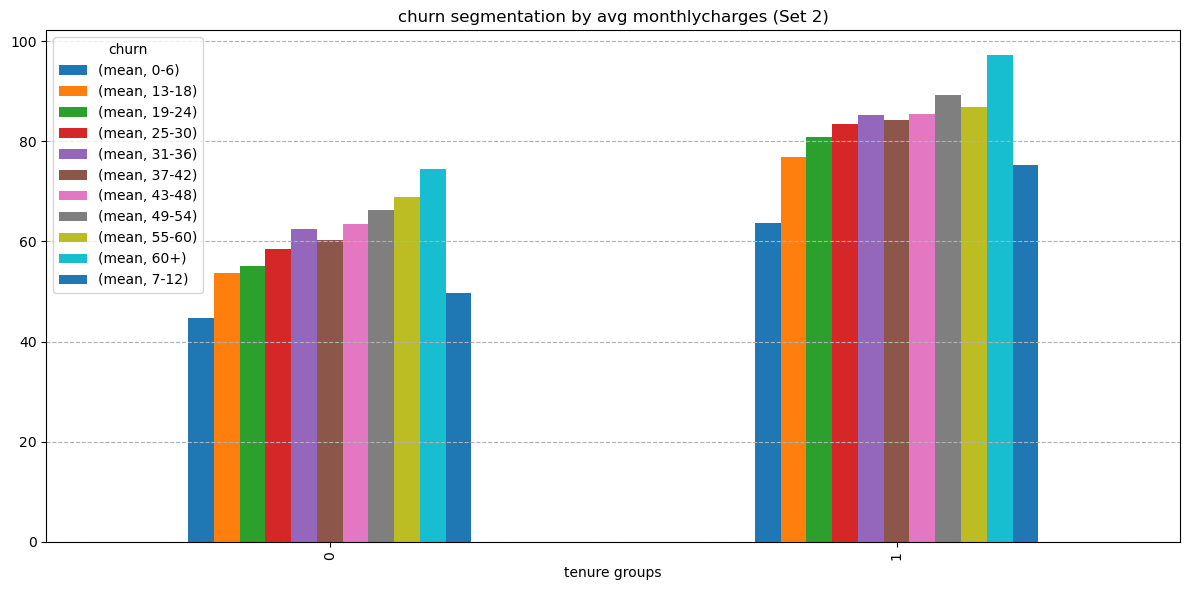

In [28]:
unstacked = stats_set2.unstack()
unstacked.plot(kind='bar', figsize=(12, 6))

plt.title('churn segmentation by avg monthlycharges (Set 2)')
plt.xlabel('tenure groups')
plt.legend(title='churn')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

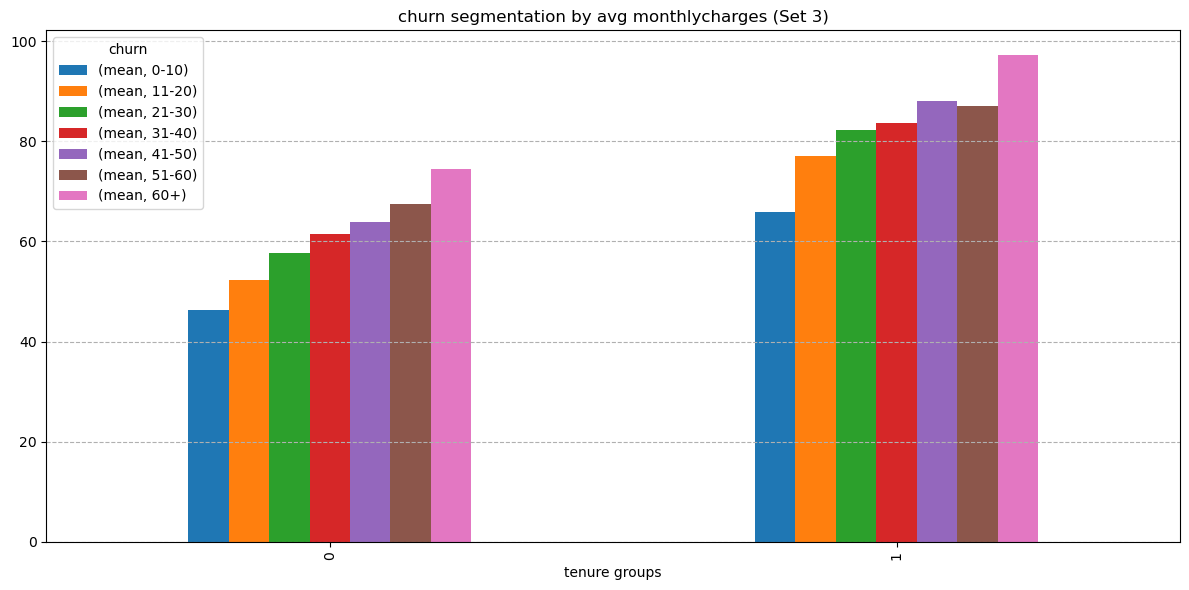

In [29]:
unstacked = stats_set3.unstack()
unstacked.plot(kind='bar', figsize=(12, 6))

plt.title('churn segmentation by avg monthlycharges (Set 3)')
plt.xlabel('tenure groups')
plt.legend(title='churn')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

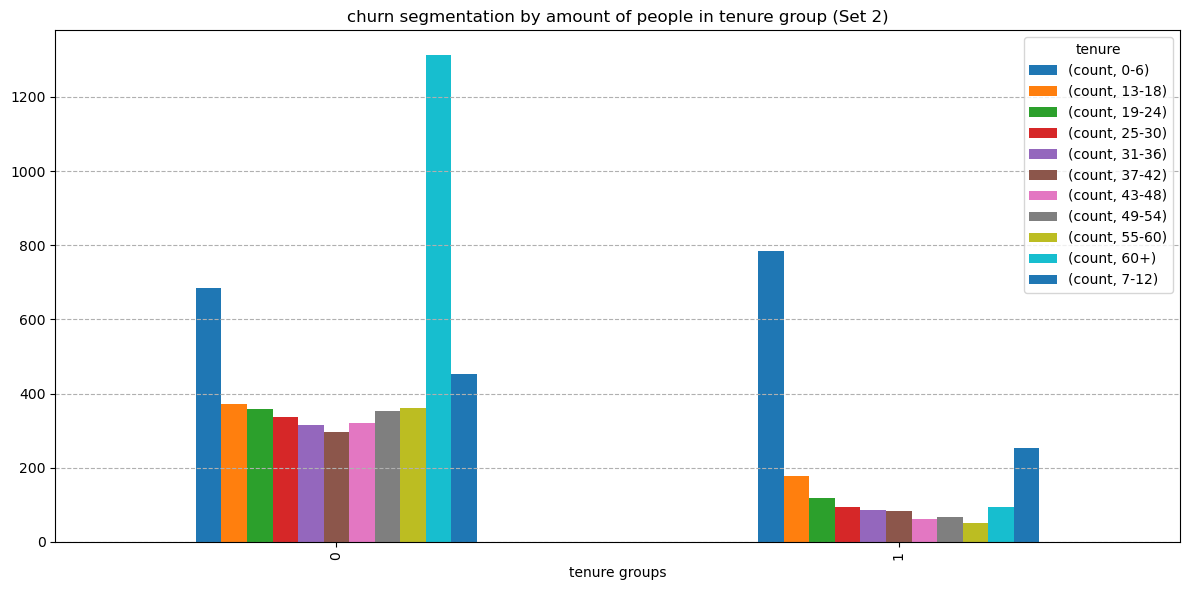

In [30]:
data_set2 = df.groupby(['churn','tenure_category_set2'])['partner'].agg(['count'])
unstacked = data_set2.unstack()
unstacked.plot(kind='bar', figsize=(12, 6))
plt.title('churn segmentation by amount of people in tenure group (Set 2)')
plt.xlabel('tenure groups')
plt.legend(title='tenure')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

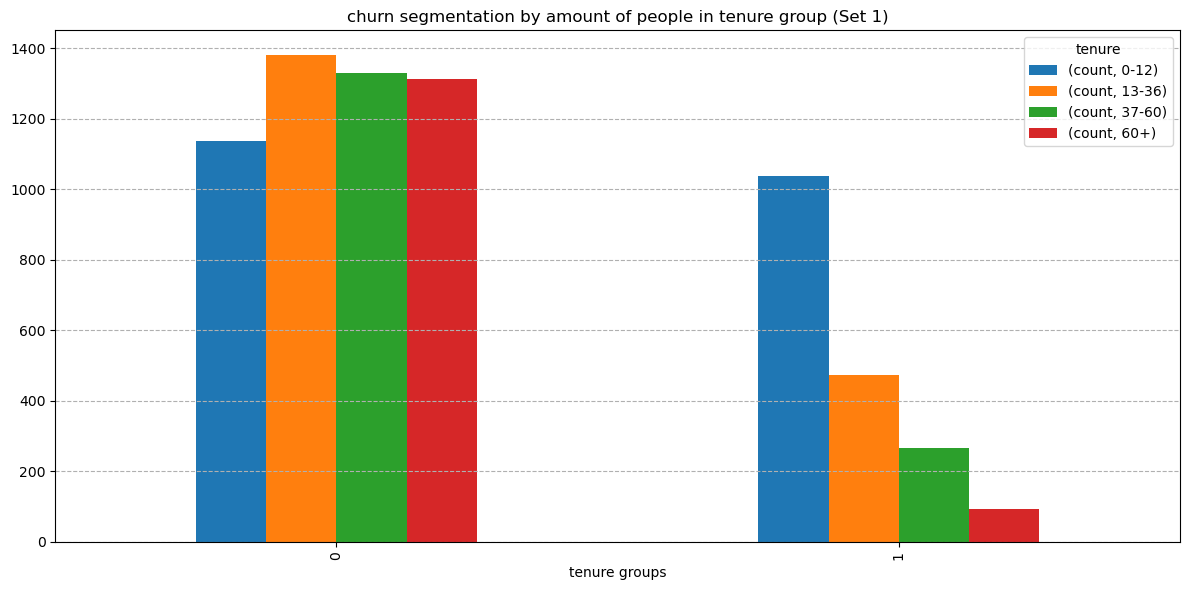

In [31]:
data_set1 = df.groupby(['churn','tenure_category_set1'])['partner'].agg(['count'])
unstacked = data_set1.unstack()
unstacked.plot(kind='bar', figsize=(12, 6))
plt.title('churn segmentation by amount of people in tenure group (Set 1)')
plt.xlabel('tenure groups')
plt.legend(title='tenure')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

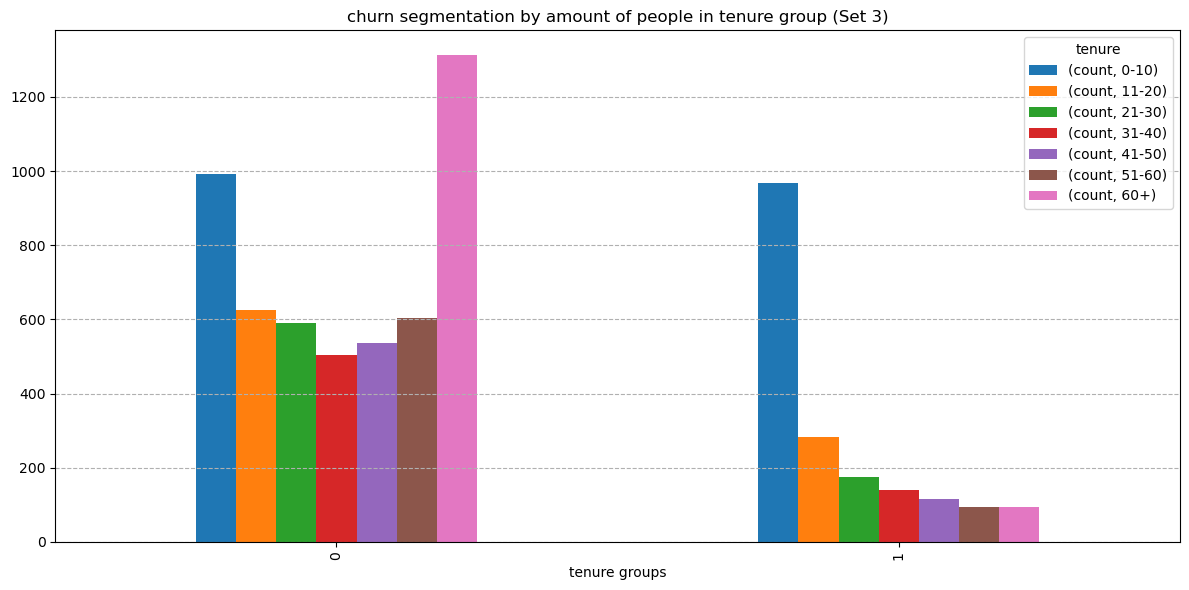

In [32]:
data_set3 = df.groupby(['churn','tenure_category_set3'])['partner'].agg(['count'])
unstacked = data_set3.unstack()
unstacked.plot(kind='bar', figsize=(12, 6))
plt.title('churn segmentation by amount of people in tenure group (Set 3)')
plt.xlabel('tenure groups')
plt.legend(title='tenure')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

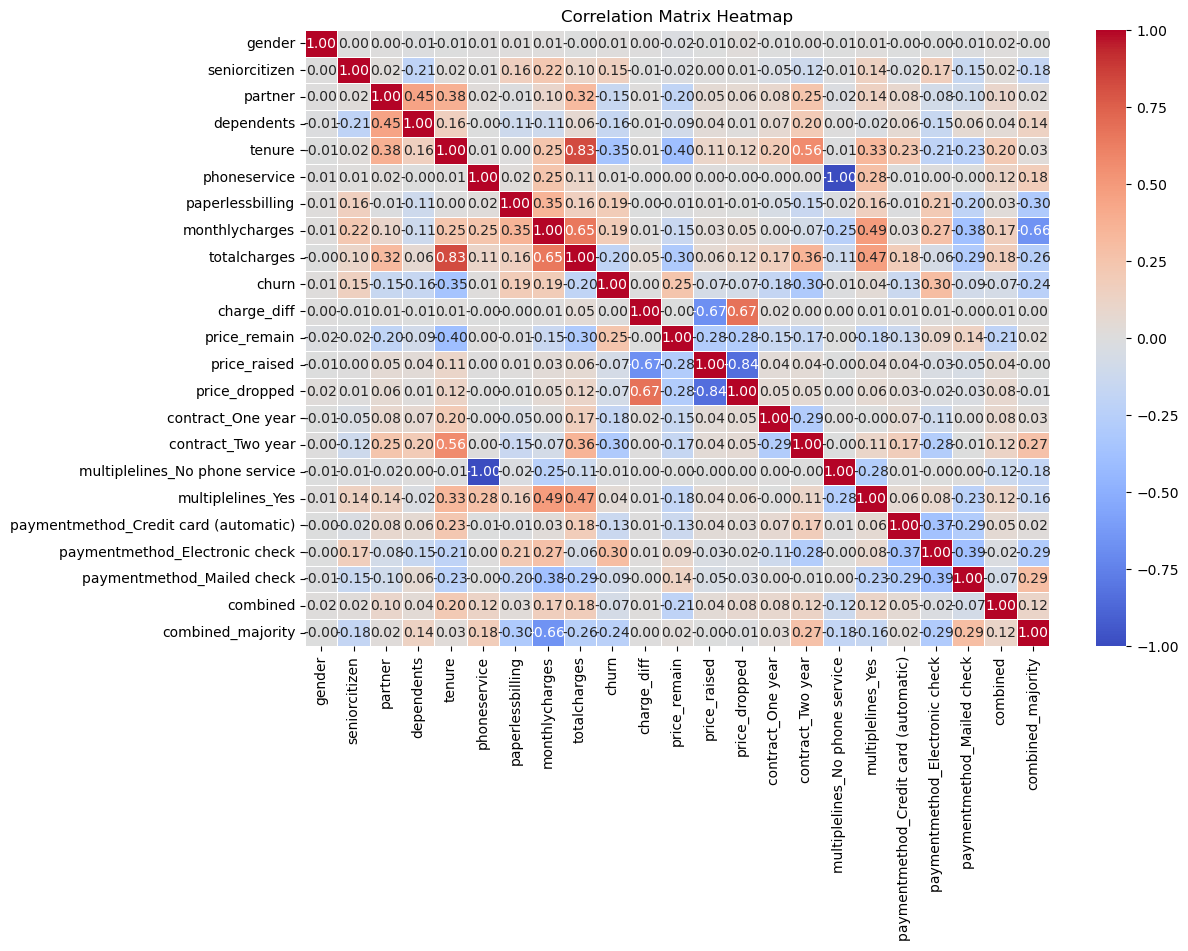

In [33]:
# חישוב קורלציות אחרי המרה
corr_matrix = df.corr(numeric_only=True)

# יצירת heatmap לכלל הנתונים
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()
#corr_matrix.index

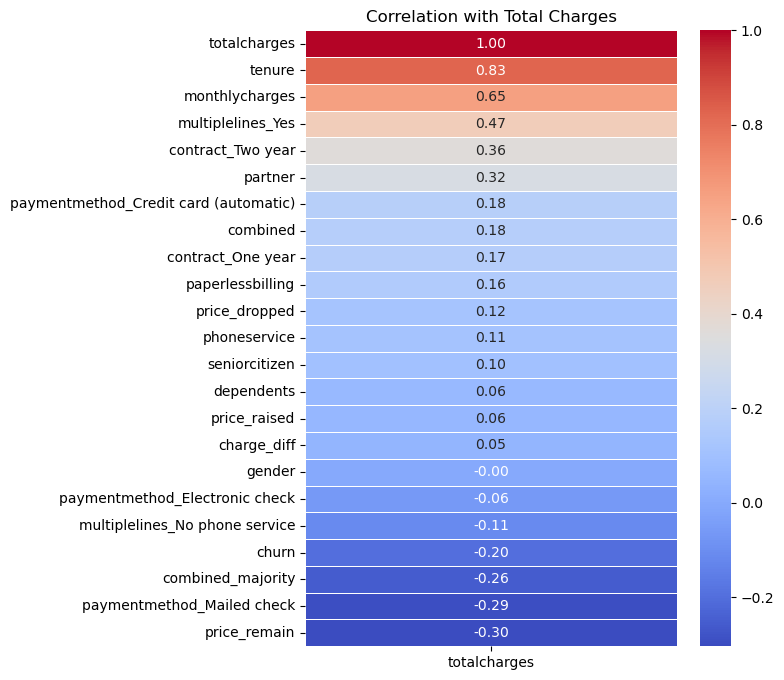

In [34]:
corr_totalcharges = corr_matrix[['totalcharges']].sort_values(by='totalcharges', ascending=False)


plt.figure(figsize=(6, 8))
sns.heatmap(corr_totalcharges, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation with Total Charges")
plt.show()


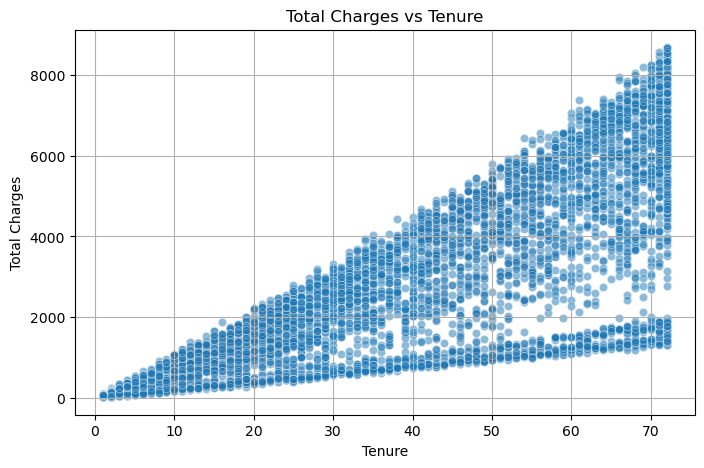

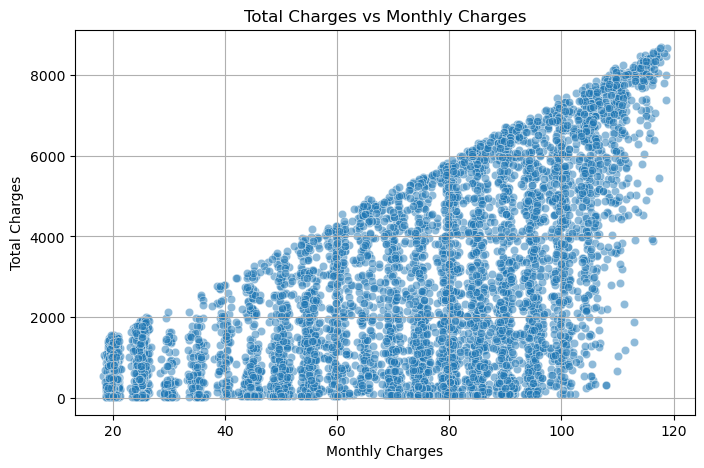

In [35]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['tenure'], y=df['totalcharges'], alpha=0.5)
plt.title("Total Charges vs Tenure")
plt.xlabel("Tenure")
plt.ylabel("Total Charges")
plt.grid()
plt.show()


#     נחוץ??
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['monthlycharges'], y=df['totalcharges'], alpha=0.5)
plt.title("Total Charges vs Monthly Charges")
plt.xlabel("Monthly Charges")
plt.ylabel("Total Charges")
plt.grid()
plt.show()


In [36]:
#ML
df = df.drop(columns=['tenure_category_set1'])
df = df.drop(columns=['tenure_category_set2'])
df = df.drop(columns=['tenure_category_set3'])


<h1> ML </h1>

In [37]:
!pip install scikit-learn
!pip install graphviz

In [38]:
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,...,price_dropped,contract_One year,contract_Two year,multiplelines_No phone service,multiplelines_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,combined,combined_majority
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,0,0,0,1,0,0,1,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,...,0,1,0,0,0,0,0,1,1,0
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,1,0,0,0,0,0,0,1,1,0
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,0,1,0,1,0,0,0,0,1,0
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1,24,1,1,84.80,1990.50,...,0,1,0,0,1,0,0,1,1,0
7039,2234-XADUH,1,0,1,1,72,1,1,103.20,7362.90,...,0,1,0,0,1,1,0,0,1,0
7040,4801-JZAZL,1,0,1,1,11,0,1,29.60,346.45,...,1,0,0,1,0,0,1,0,1,0
7041,8361-LTMKD,0,1,1,0,4,1,1,74.40,306.60,...,1,0,0,0,1,0,0,1,1,0


In [39]:
round(df.index.size * 0.2)

1406

In [40]:
from sklearn.model_selection import train_test_split

test_size = round(df.index.size * 0.2)
train, test = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)

label = 'churn'
cus_id = 'customerid'

x_train = train.drop(label, axis=1)
x_train = x_train.drop(cus_id, axis=1)
y_train = train[label]
cus_id_train = train[cus_id]

x_test = test.drop(label, axis=1)
x_test = x_test.drop(cus_id, axis=1)
y_test = test[label]
cus_id_test = test[cus_id]

In [41]:
train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,...,price_dropped,contract_One year,contract_Two year,multiplelines_No phone service,multiplelines_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,combined,combined_majority
3984,5884-FBCTL,1,0,1,1,72,1,0,25.10,1857.85,...,1,0,1,0,1,0,0,0,1,1
6030,2027-OAQQC,1,0,0,0,43,0,1,49.05,2076.20,...,0,0,0,1,0,0,0,0,1,0
3410,4918-QLLIW,0,0,0,0,3,1,0,53.40,188.70,...,1,0,0,0,0,1,0,0,1,0
5483,5536-SLHPM,1,0,1,0,55,1,1,77.75,4458.15,...,1,0,0,0,1,0,1,0,1,0
5524,1716-LSAMB,0,0,1,1,45,1,0,54.65,2553.70,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,9631-XEYKE,0,0,0,0,3,1,0,50.40,137.25,...,0,0,0,0,1,0,0,0,0,0
5199,7245-JMTTQ,1,0,0,0,51,1,1,111.50,5703.25,...,1,1,0,0,1,0,1,0,1,0
5235,4299-SIMNS,0,0,0,0,9,1,1,81.15,784.45,...,1,0,0,0,1,0,1,0,1,0
5399,2589-AYCRP,1,0,0,0,50,1,0,19.75,989.05,...,1,1,0,0,0,0,0,0,1,1


In [42]:
test

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,...,price_dropped,contract_One year,contract_Two year,multiplelines_No phone service,multiplelines_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,combined,combined_majority
2481,6614-YWYSC,0,1,1,0,61,1,0,25.00,1501.75,...,0,0,1,0,1,0,0,0,1,1
6784,9546-KDTRB,1,0,0,0,19,1,0,24.70,465.85,...,0,0,0,0,1,0,0,0,1,1
6125,0871-URUWO,0,0,1,0,13,1,1,102.25,1359.00,...,1,0,0,0,1,1,0,0,1,0
3052,5151-HQRDG,0,0,1,0,37,1,1,55.05,2030.75,...,0,0,0,0,1,0,0,1,1,0
4099,6624-JDRDS,1,0,0,0,6,0,0,29.45,161.45,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,7767-UXAGJ,0,0,0,0,1,1,1,50.45,50.45,...,0,0,0,0,1,0,1,0,0,0
1733,1015-OWJKI,0,0,0,0,1,1,0,19.05,19.05,...,0,0,0,0,0,0,0,1,1,1
5250,3338-CVVEH,0,0,0,0,12,1,0,94.55,1173.55,...,1,0,0,0,1,0,1,0,1,0
5465,6933-FHBZC,1,0,0,0,26,1,1,56.05,1553.20,...,1,1,0,0,0,0,0,1,1,0


In [43]:
x_train

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,charge_diff,...,price_dropped,contract_One year,contract_Two year,multiplelines_No phone service,multiplelines_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,combined,combined_majority
3984,1,0,1,1,72,1,0,25.10,1857.85,50.65,...,1,0,1,0,1,0,0,0,1,1
6030,1,0,0,0,43,0,1,49.05,2076.20,-32.95,...,0,0,0,1,0,0,0,0,1,0
3410,0,0,0,0,3,1,0,53.40,188.70,28.50,...,1,0,0,0,0,1,0,0,1,0
5483,1,0,1,0,55,1,1,77.75,4458.15,181.90,...,1,0,0,0,1,0,1,0,1,0
5524,0,0,1,1,45,1,0,54.65,2553.70,94.45,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,0,0,0,0,3,1,0,50.40,137.25,-13.95,...,0,0,0,0,1,0,0,0,0,0
5199,1,0,0,0,51,1,1,111.50,5703.25,16.75,...,1,1,0,0,1,0,1,0,1,0
5235,0,0,0,0,9,1,1,81.15,784.45,54.10,...,1,0,0,0,1,0,1,0,1,0
5399,1,0,0,0,50,1,0,19.75,989.05,1.55,...,1,1,0,0,0,0,0,0,1,1


In [44]:
x_test

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,charge_diff,...,price_dropped,contract_One year,contract_Two year,multiplelines_No phone service,multiplelines_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,combined,combined_majority
2481,0,1,1,0,61,1,0,25.00,1501.75,-23.25,...,0,0,1,0,1,0,0,0,1,1
6784,1,0,0,0,19,1,0,24.70,465.85,-3.45,...,0,0,0,0,1,0,0,0,1,1
6125,0,0,1,0,13,1,1,102.25,1359.00,29.75,...,1,0,0,0,1,1,0,0,1,0
3052,0,0,1,0,37,1,1,55.05,2030.75,-6.10,...,0,0,0,0,1,0,0,1,1,0
4099,1,0,0,0,6,0,0,29.45,161.45,-15.25,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,0,0,0,0,1,1,1,50.45,50.45,0.00,...,0,0,0,0,1,0,1,0,0,0
1733,0,0,0,0,1,1,0,19.05,19.05,0.00,...,0,0,0,0,0,0,0,1,1,1
5250,0,0,0,0,12,1,0,94.55,1173.55,38.95,...,1,0,0,0,1,0,1,0,1,0
5465,1,0,0,0,26,1,1,56.05,1553.20,95.90,...,1,1,0,0,0,0,0,1,1,0


In [45]:
y_train

3984    0
6030    1
3410    1
5483    1
5524    0
       ..
3778    0
5199    0
5235    0
5399    0
862     1
Name: churn, Length: 5626, dtype: int64

In [46]:
y_test

2481    0
6784    0
6125    1
3052    0
4099    0
       ..
1428    1
1733    0
5250    0
5465    0
5851    0
Name: churn, Length: 1406, dtype: int64

In [47]:
cus_id_train

3984    5884-FBCTL
6030    2027-OAQQC
3410    4918-QLLIW
5483    5536-SLHPM
5524    1716-LSAMB
           ...    
3778    9631-XEYKE
5199    7245-JMTTQ
5235    4299-SIMNS
5399    2589-AYCRP
862     0947-MUGVO
Name: customerid, Length: 5626, dtype: object

In [48]:
cus_id_test

2481    6614-YWYSC
6784    9546-KDTRB
6125    0871-URUWO
3052    5151-HQRDG
4099    6624-JDRDS
           ...    
1428    7767-UXAGJ
1733    1015-OWJKI
5250    3338-CVVEH
5465    6933-FHBZC
5851    4118-CEVPF
Name: customerid, Length: 1406, dtype: object

In [49]:
x_train.shape, y_train.shape, cus_id_train.shape, x_test.shape, y_test.shape, cus_id_test.shape

((5626, 22), (5626,), (5626,), (1406, 22), (1406,), (1406,))

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

original_x_train = x_train
original_x_test = x_test

x_train = scaler.fit_transform(x_train) 
x_test = scaler.transform(x_test) 

In [51]:
original_x_train

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,charge_diff,...,price_dropped,contract_One year,contract_Two year,multiplelines_No phone service,multiplelines_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,combined,combined_majority
3984,1,0,1,1,72,1,0,25.10,1857.85,50.65,...,1,0,1,0,1,0,0,0,1,1
6030,1,0,0,0,43,0,1,49.05,2076.20,-32.95,...,0,0,0,1,0,0,0,0,1,0
3410,0,0,0,0,3,1,0,53.40,188.70,28.50,...,1,0,0,0,0,1,0,0,1,0
5483,1,0,1,0,55,1,1,77.75,4458.15,181.90,...,1,0,0,0,1,0,1,0,1,0
5524,0,0,1,1,45,1,0,54.65,2553.70,94.45,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,0,0,0,0,3,1,0,50.40,137.25,-13.95,...,0,0,0,0,1,0,0,0,0,0
5199,1,0,0,0,51,1,1,111.50,5703.25,16.75,...,1,1,0,0,1,0,1,0,1,0
5235,0,0,0,0,9,1,1,81.15,784.45,54.10,...,1,0,0,0,1,0,1,0,1,0
5399,1,0,0,0,50,1,0,19.75,989.05,1.55,...,1,1,0,0,0,0,0,0,1,1


In [52]:
x_train

array([[ 1.0136012 , -0.43754349,  1.03878945, ..., -0.54736396,
         0.20692371,  1.78319712],
       [ 1.0136012 , -0.43754349, -0.96265899, ..., -0.54736396,
         0.20692371, -0.5607905 ],
       [-0.98658131, -0.43754349, -0.96265899, ..., -0.54736396,
         0.20692371, -0.5607905 ],
       ...,
       [-0.98658131, -0.43754349, -0.96265899, ..., -0.54736396,
         0.20692371, -0.5607905 ],
       [ 1.0136012 , -0.43754349, -0.96265899, ..., -0.54736396,
         0.20692371,  1.78319712],
       [-0.98658131,  2.28548711,  1.03878945, ..., -0.54736396,
         0.20692371, -0.5607905 ]])

In [53]:
#!pip install graphviz

# Plotting the decision tree
# Importing the necessary libraries
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

# this is a function that we can always use for plotting decision trees, the function expects 3 arg as follows
def plot_tree(tree, features, labels):
    graph = Source(export_graphviz(tree, feature_names=features, class_names=labels, filled = True))
    display(SVG(graph.pipe(format='svg')))

<h2> Decision Tree </h2>

In [104]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(max_depth=6)
model.fit(x_train, y_train) 

y_test_pred_DecisionTree = model.predict(x_test)

output = pd.DataFrame({cus_id: cus_id_test, 'churned_what_actualy_happened':y_test, 'churned_predicted_by_model': y_test_pred_DecisionTree}) 

test_acc = accuracy_score(y_test, y_test_pred_DecisionTree)

print("Accuracy = ", test_acc)
output.head(10)

Accuracy =  0.7788051209103841


,customerid,churned_what_actualy_happened,churned_predicted_by_model
2481,6614-YWYSC,0,0
6784,9546-KDTRB,0,0
6125,0871-URUWO,1,1
3052,5151-HQRDG,0,0
4099,6624-JDRDS,0,0
3223,3082-VQXNH,0,1
3774,1309-XGFSN,0,0
3469,9402-ORRAH,0,1
3420,8663-UPDGF,0,0
1196,0455-ENTCR,0,0


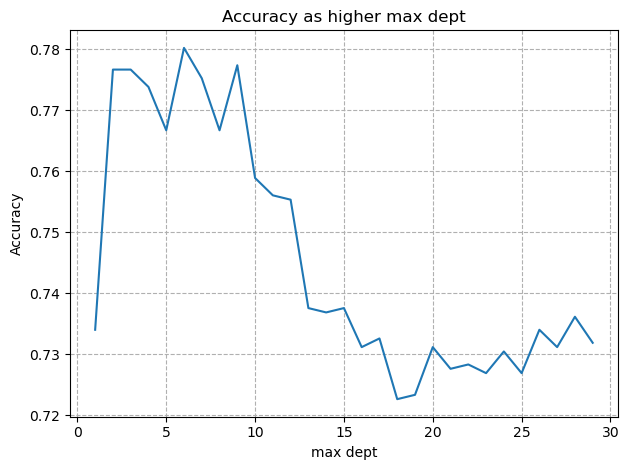

maximum accuracy at max dept:6 with accuracy=0.7802275960170697


In [117]:
iterations = list(range(1,30))
test_acc = []
for max_dept in iterations:
    model = DecisionTreeClassifier(max_depth=max_dept)
    model.fit(x_train, y_train) 
    y_test_pred_DecisionTree = model.predict(x_test)
    output = pd.DataFrame({cus_id: cus_id_test, 'churned_what_actualy_happened':y_test, 'churned_predicted_by_model': y_test_pred_DecisionTree}) 
    test_acc.append( accuracy_score(y_test, y_test_pred_DecisionTree) )

plt.plot(iterations, test_acc)
plt.title('Accuracy as higher max dept')
plt.xlabel('max dept')
plt.ylabel('Accuracy')
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

d = dict(zip(test_acc,iterations))
print(f"maximum accuracy at max dept:{d[max(d.keys())]} with accuracy={max(d.keys())}") 

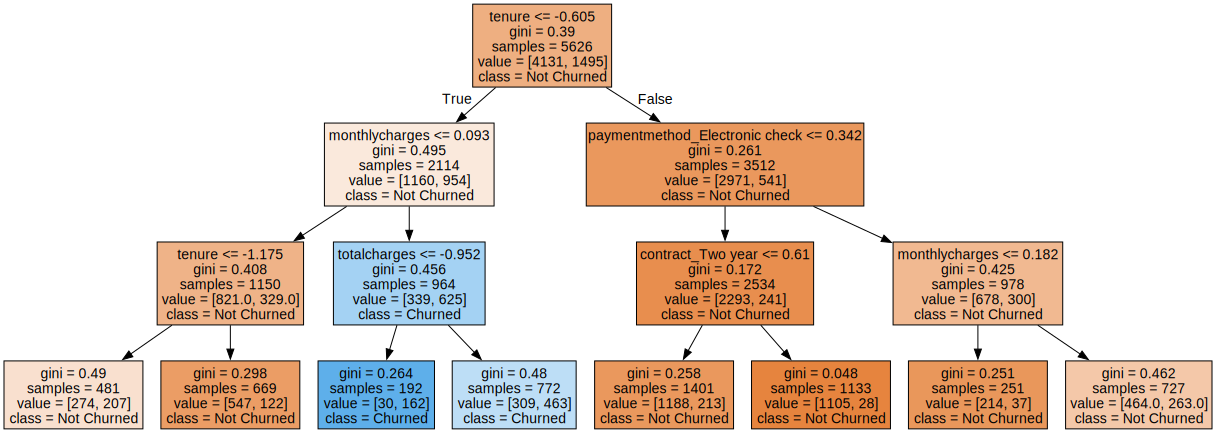

In [55]:
plot_tree(model, original_x_train.columns, ['Not Churned', 'Churned'])

<h2> Random Forest model </h2>

In [122]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=24, max_depth=9, random_state=1)

model.fit(x_train, y_train) 

y_test_pred_RandomForest = model.predict(x_test) 

output = pd.DataFrame({cus_id: cus_id_test, 'churned_what_actualy_happened':y_test, 'churned_predicted_by_model': y_test_pred_RandomForest})

test_acc = accuracy_score(y_test, y_test_pred_RandomForest)
print("Accuracy = ", test_acc)
output.head(10)

Accuracy =  0.8001422475106685


,customerid,churned_what_actualy_happened,churned_predicted_by_model
2481,6614-YWYSC,0,0
6784,9546-KDTRB,0,0
6125,0871-URUWO,1,0
3052,5151-HQRDG,0,0
4099,6624-JDRDS,0,0
3223,3082-VQXNH,0,0
3774,1309-XGFSN,0,0
3469,9402-ORRAH,0,1
3420,8663-UPDGF,0,0
1196,0455-ENTCR,0,0


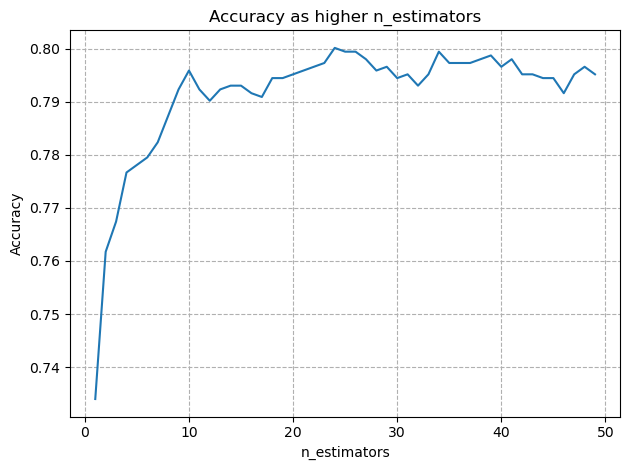

maximum accuracy at n_estimators:24 with accuracy=0.8001422475106685


In [121]:
iterations = list(range(1,50))
test_acc = []
for n in iterations:
    model = RandomForestClassifier(n_estimators=n, max_depth=9, random_state=1)
    model.fit(x_train, y_train) 
    y_test_pred_RandomForest = model.predict(x_test) 
    output = pd.DataFrame({cus_id: cus_id_test, 'churned_what_actualy_happened':y_test, 'churned_predicted_by_model': y_test_pred_RandomForest})
    test_acc.append( accuracy_score(y_test, y_test_pred_RandomForest) )

plt.plot(iterations, test_acc)
plt.title('Accuracy as higher n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

d = dict(zip(test_acc,iterations))
print(f"maximum accuracy at n_estimators:{d[max(d.keys())]} with accuracy={max(d.keys())}") 

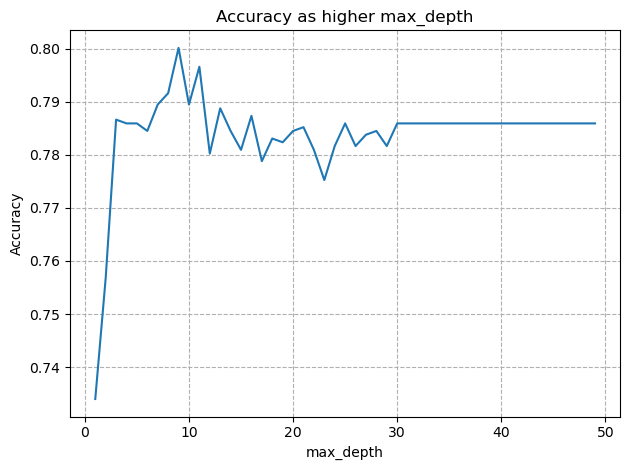

maximum accuracy at max_depth:9 with accuracy=0.8001422475106685


In [123]:
iterations = list(range(1,50))
test_acc = []
for n in iterations:
    model = RandomForestClassifier(n_estimators=24, max_depth=n, random_state=1)
    model.fit(x_train, y_train) 
    y_test_pred_RandomForest = model.predict(x_test) 
    output = pd.DataFrame({cus_id: cus_id_test, 'churned_what_actualy_happened':y_test, 'churned_predicted_by_model': y_test_pred_RandomForest})
    test_acc.append( accuracy_score(y_test, y_test_pred_RandomForest) )

plt.plot(iterations, test_acc)
plt.title('Accuracy as higher max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

d = dict(zip(test_acc,iterations))
print(f"maximum accuracy at max_depth:{d[max(d.keys())]} with accuracy={max(d.keys())}") 

<h2> KNN - K Nearest Neighbors </h2>

In [125]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=39)

model.fit(x_train, y_train) 

y_test_pred_KNN = model.predict(x_test) 

output = pd.DataFrame({cus_id: cus_id_test, 'churned_what_actualy_happened':y_test, 'churned_predicted_by_model': y_test_pred_KNN})

test_acc = accuracy_score(y_test, y_test_pred_KNN)
print("Accuracy = ", test_acc)
output.head(10)

Accuracy =  0.7837837837837838


,customerid,churned_what_actualy_happened,churned_predicted_by_model
2481,6614-YWYSC,0,0
6784,9546-KDTRB,0,0
6125,0871-URUWO,1,0
3052,5151-HQRDG,0,0
4099,6624-JDRDS,0,0
3223,3082-VQXNH,0,0
3774,1309-XGFSN,0,0
3469,9402-ORRAH,0,1
3420,8663-UPDGF,0,1
1196,0455-ENTCR,0,0


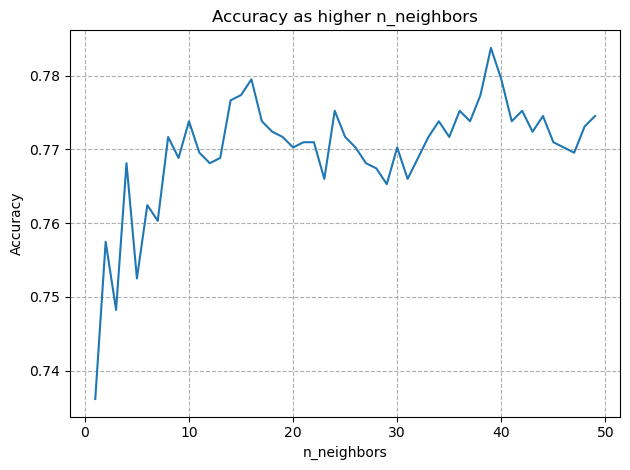

maximum accuracy at n_neighbors:39 with accuracy=0.7837837837837838


In [127]:
iterations = list(range(1,50))
test_acc = []
for n in iterations:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(x_train, y_train) 
    y_test_pred_KNN = model.predict(x_test) 
    output = pd.DataFrame({cus_id: cus_id_test, 'churned_what_actualy_happened':y_test, 'churned_predicted_by_model': y_test_pred_KNN})
    test_acc.append( accuracy_score(y_test, y_test_pred_KNN) ) 

plt.plot(iterations, test_acc)
plt.title('Accuracy as higher n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

d = dict(zip(test_acc,iterations))
print(f"maximum accuracy at n_neighbors:{d[max(d.keys())]} with accuracy={max(d.keys())}") 

In [58]:
import numpy as np
def get_benchmark_predictions(x, benchmark_value): # The function returns a numpy array on the same length as x with all values equal to benchmark_value
    return np.ones(len(x))*benchmark_value

In [59]:
benchmark_value = 0

y_test_pred_Benchmark_0 = get_benchmark_predictions(x_test, benchmark_value)
test_acc = accuracy_score(y_test, y_test_pred_Benchmark_0)
print("Accuracy = ", test_acc)

Accuracy =  0.7339971550497866
